Parsing ./logs/t2/mobilemamba_t2.txt...
  - Train records: 301, Test records: 280
Parsing ./logs/t2/starnett2.txt...
  - Train records: 401, Test records: 480


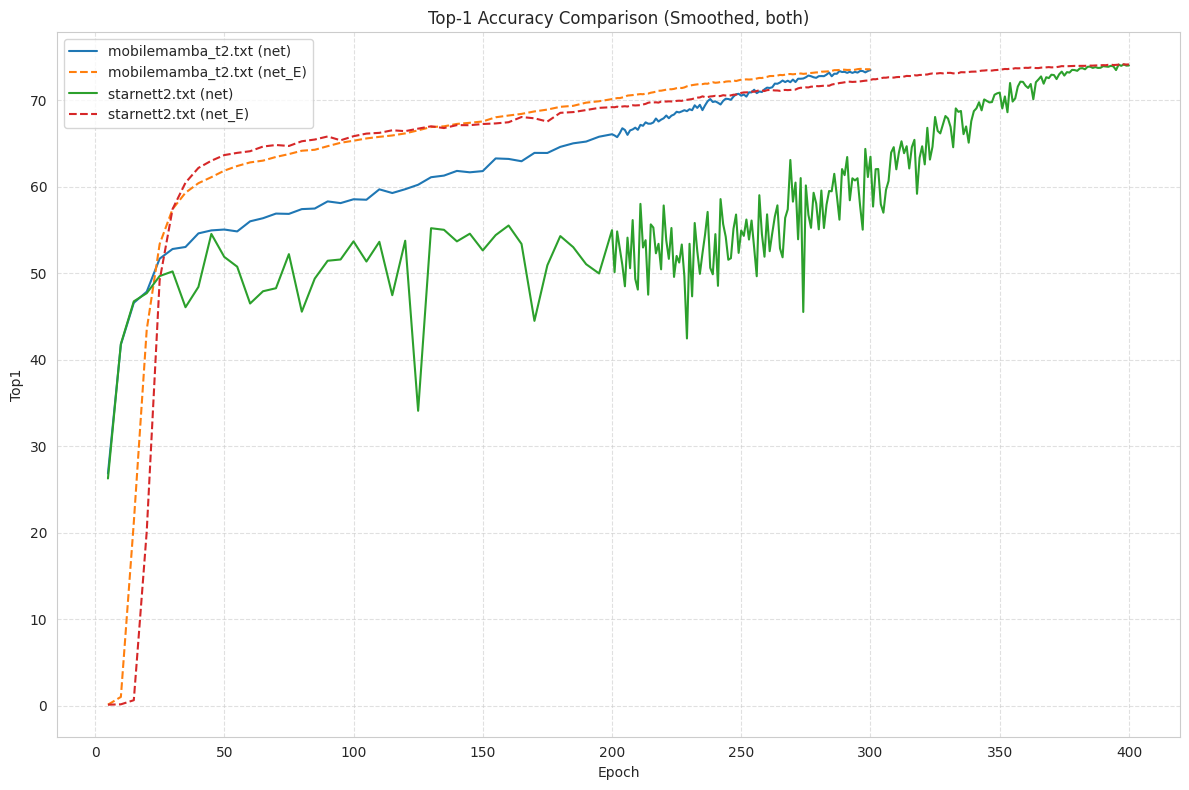

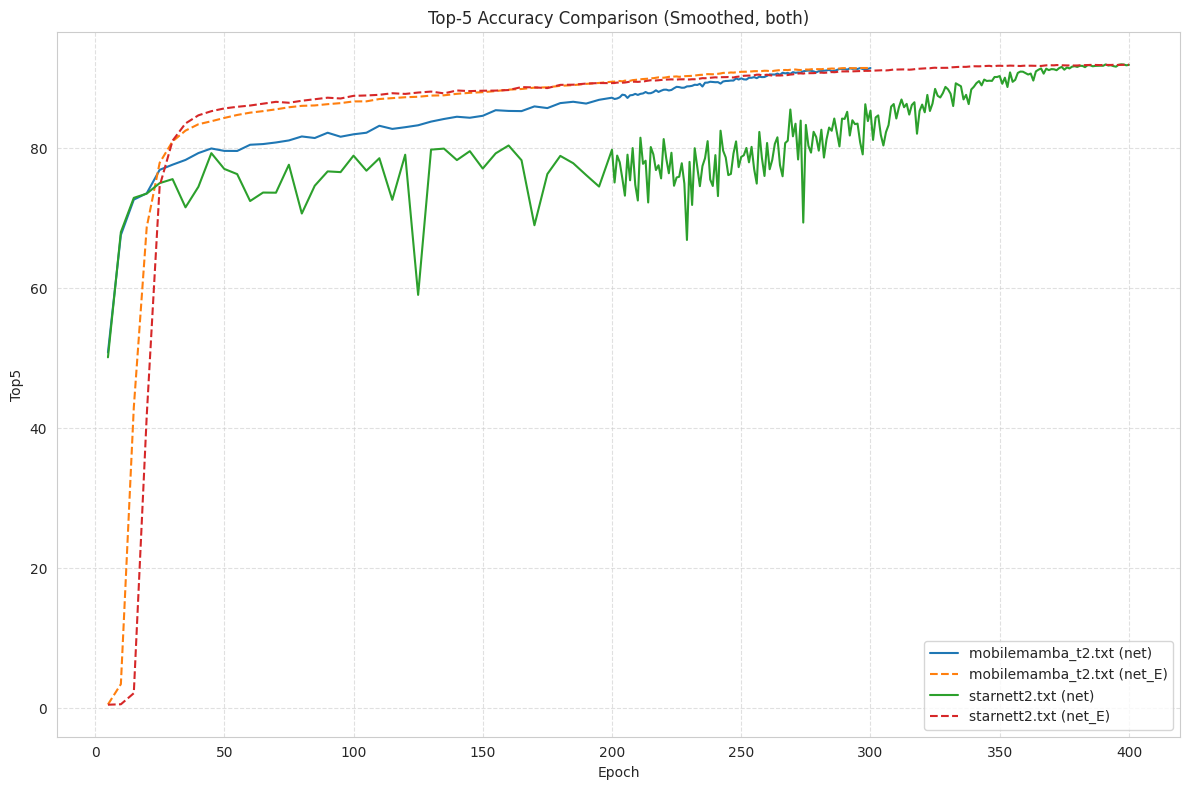

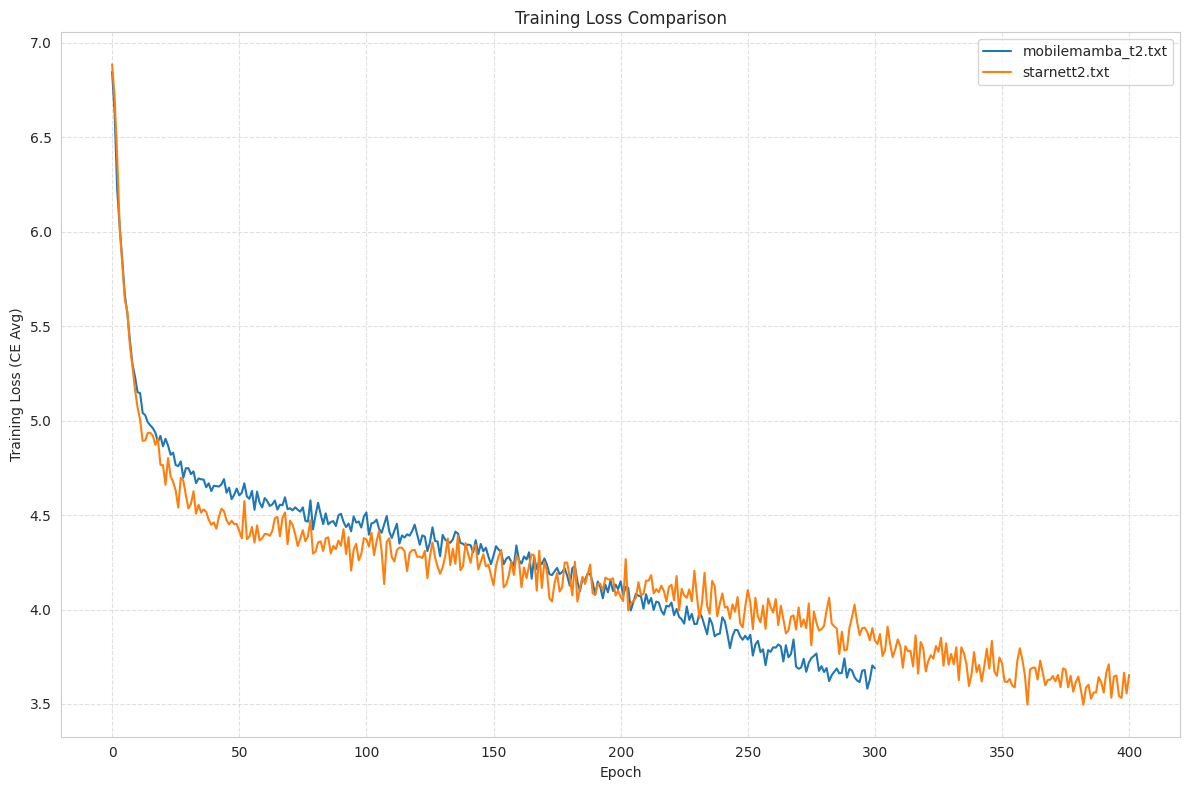

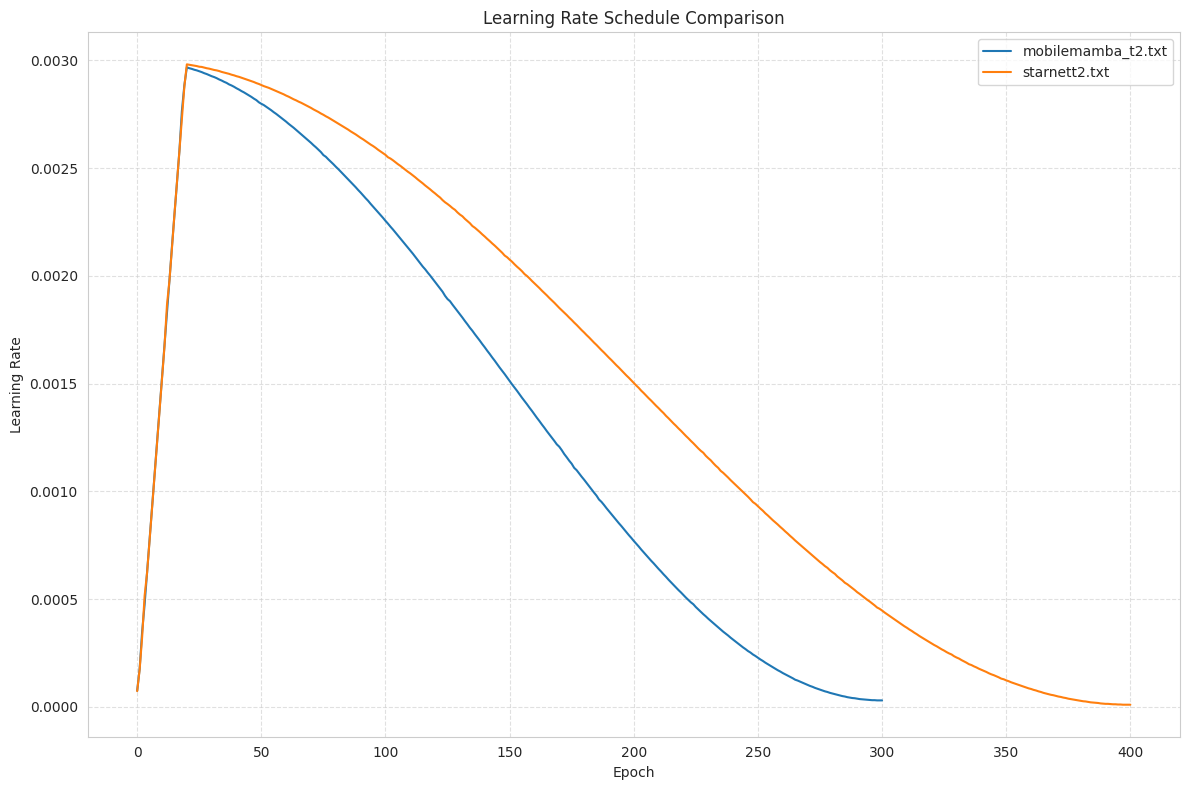


Visualization complete. Check the plots generated by matplotlib.


In [2]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import uniform_filter1d

sns.set_style("whitegrid")

# --- 配置 ---
LOG_DIR = './logs/t2'          # 请将你的日志文件放入此目录
SMOOTH = False              # 是否启用平滑
SMOOTH_WINDOW = 0           # 平滑窗口大小
MODEL_TYPE = 'both'         # 可选: 'net', 'net_E', 'both'

def parse_log_file(log_path):
    """
    从日志文件中解析出训练和测试数据（包括 EMA 模型）
    """
    train_data = []
    test_data = []

    last_train_epoch = 0  # 记录最近一次训练的 epoch，用于关联测试结果

    with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()

    for line in lines:
        # --- 匹配训练日志 ---
        train_match = re.search(
            r"Train:.*?\[\d+/\d+\].*?\[([\d\.]+)/([\d\.]+)\].*?"  # [4.0/400.0]
            r"\[lr ([\d\.e\-]+)\].*?"                             # [lr 0.000150]
            r"\[CE ([\d\.]+) \(([\d\.]+)\)\]",                    # [CE 5.927 (6.109)]
            line
        )
        if train_match:
            current_epoch_float = float(train_match.group(1))  # 如 4.0
            total_epochs = float(train_match.group(2))         # 如 400.0
            lr = float(train_match.group(3))
            ce_loss = float(train_match.group(4))
            ce_avg = float(train_match.group(5))

            epoch = int(current_epoch_float)
            last_train_epoch = epoch

            train_data.append({
                'epoch': epoch,
                'lr': lr,
                'ce_loss': ce_loss,
                'ce_avg': ce_avg
            })

        # --- 匹配原始模型 (net) 的测试结果 ---
        test_net_match = re.search(r"net: ([\d\.]+) \(([\d\.]+)\)", line)
        if test_net_match:
            top1 = float(test_net_match.group(1))
            top5 = float(test_net_match.group(2))
            test_epoch = last_train_epoch
            test_data.append({
                'epoch': test_epoch,
                'model_type': 'net', # 标记为原始模型
                'top1': top1,
                'top5': top5
            })

        # --- 匹配 EMA 模型 (net_E) 的测试结果 ---
        test_net_e_match = re.search(r"net_E: ([\d\.]+) \(([\d\.]+)\)", line)
        if test_net_e_match:
            top1_ema = float(test_net_e_match.group(1))
            top5_ema = float(test_net_e_match.group(2))
            # EMA 模型的测试通常与原始模型在同一 epoch 进行
            test_epoch_ema = last_train_epoch
            test_data.append({
                'epoch': test_epoch_ema,
                'model_type': 'net_E', # 标记为 EMA 模型
                'top1': top1_ema,
                'top5': top5_ema
            })

    # 去重训练数据
    if train_data: # 修正：检查列表是否非空
        train_df = pd.DataFrame(train_data)
        train_df = train_df.sort_values(by='epoch').drop_duplicates(subset=['epoch'], keep='last')
    else:
        train_df = pd.DataFrame(columns=['epoch', 'lr', 'ce_loss', 'ce_avg'])

    # 测试数据去重（按 epoch 和 model_type）
    if test_data: # 修正：检查列表是否非空
        test_df = pd.DataFrame(test_data)
        test_df = test_df.drop_duplicates(subset=['epoch', 'model_type']).sort_values(by=['model_type', 'epoch'])
    else:
        test_df = pd.DataFrame(columns=['epoch', 'model_type', 'top1', 'top5'])

    return train_df, test_df




def parse_logs_in_dir(log_dir):
    """
    解析指定目录下的所有日志文件
    """
    logs = {}
    for fname in os.listdir(log_dir):
        if fname.endswith('.txt') or 'log' in fname.lower():
            path = os.path.join(log_dir, fname)
            print(f"Parsing {path}...")
            try:
                train_df, test_df = parse_log_file(path)
                logs[fname] = {'train': train_df, 'test': test_df}
                print(f"  - Train records: {len(train_df)}, Test records: {len(test_df)}")
            except Exception as e:
                print(f"  - Error parsing {path}: {e}")
    return logs

def apply_moving_average(df, column, window_size=5):
    """
    对 DataFrame 的指定列应用移动平均以平滑曲线
    """
    if df.empty or column not in df.columns:
        return df
    smoothed_values = uniform_filter1d(df[column].values, size=window_size, mode='nearest')
    df_smoothed = df.copy()
    df_smoothed[column + '_smoothed'] = smoothed_values
    return df_smoothed

def plot_comparison(logs, metric='top1', title=None, smooth=True, smooth_window=5, model_type='both'):
    """
    对比多个日志的某个指标 (支持 net 和 net_E)，可根据 model_type 选择显示
    """
    if title is None:
        title = f'{metric.title()} Comparison'

    plt.figure(figsize=(12, 8))
    has_data = False
    for name, data in logs.items():
        df = data['test']
        if not df.empty and metric in df.columns and len(df) > 0:
            # 根据 MODEL_TYPE 选择要绘制的数据
            if model_type == 'net':
                selected_df = df[df['model_type'] == 'net']
                label_suffix = ' (net)'
                linestyle = '-'
            elif model_type == 'net_E':
                selected_df = df[df['model_type'] == 'net_E']
                label_suffix = ' (net_E)'
                linestyle = '-'
            elif model_type == 'both':
                selected_df = df # 使用全部数据
                # 不需要后缀，因为会在下面分别处理 net 和 net_E
            else:
                print(f"Warning: Invalid model_type '{model_type}'. Skipping {name}.")
                continue

            if model_type == 'both':
                # 分离 net 和 net_E 的数据
                net_df = df[df['model_type'] == 'net']
                net_e_df = df[df['model_type'] == 'net_E']

                if not net_df.empty:
                    if smooth:
                        net_df_smoothed = apply_moving_average(net_df, metric, window_size=smooth_window)
                        plt.plot(net_df_smoothed['epoch'], net_df_smoothed[f'{metric}_smoothed'], label=f'{name} (net)', linewidth=1.5, linestyle='-')
                    else:
                        plt.plot(net_df['epoch'], net_df[metric], label=f'{name} (net)', linewidth=1.5, linestyle='-')
                    has_data = True

                if not net_e_df.empty:
                    if smooth:
                        net_e_df_smoothed = apply_moving_average(net_e_df, metric, window_size=smooth_window)
                        plt.plot(net_e_df_smoothed['epoch'], net_e_df_smoothed[f'{metric}_smoothed'], label=f'{name} (net_E)', linewidth=1.5, linestyle='--')
                    else:
                        plt.plot(net_e_df['epoch'], net_e_df[metric], label=f'{name} (net_E)', linewidth=1.5, linestyle='--')
                    has_data = True
            else:
                # 绘制指定的 model_type
                if not selected_df.empty:
                    if smooth:
                        selected_df_smoothed = apply_moving_average(selected_df, metric, window_size=smooth_window)
                        plt.plot(selected_df_smoothed['epoch'], selected_df_smoothed[f'{metric}_smoothed'], label=f'{name}{label_suffix}', linewidth=1.5, linestyle=linestyle)
                    else:
                        plt.plot(selected_df['epoch'], selected_df[metric], label=f'{name}{label_suffix}', linewidth=1.5, linestyle=linestyle)
                    has_data = True

        else:
            print(f"Warning: {name} does not contain sufficient '{metric}' test data.")

    if has_data: # 修正：使用正确的变量名
        plt.xlabel('Epoch')
        plt.ylabel(metric.title())
        plt.title(title)
        plt.legend(loc='best')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No test data available for {metric} comparison with model_type '{model_type}'.")

def plot_train_loss_comparison(logs, smooth=True, smooth_window=5):
    """
    对比多个日志的训练 loss
    """
    plt.figure(figsize=(12, 8))
    has_data = False
    for name, data in logs.items():
        df = data['train']
        metric = 'ce_avg'
        if not df.empty and metric in df.columns and len(df) > 0:
            if smooth:
                df_smoothed = apply_moving_average(df, metric, window_size=smooth_window)
                plt.plot(df_smoothed['epoch'], df_smoothed[f'{metric}_smoothed'], label=name, linewidth=1.5)
            else:
                plt.plot(df['epoch'], df[metric], label=name, linewidth=1.5)
            has_data = True
        else:
            print(f"Warning: {name} does not contain sufficient '{metric}' data.")


    if has_data: # 修正：使用正确的变量名
        plt.xlabel('Epoch')
        plt.ylabel('Training Loss (CE Avg)')
        plt.title('Training Loss Comparison')
        plt.legend(loc='best')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
    else:
        print("No data available for training loss comparison.")

def plot_lr_comparison(logs, smooth=True, smooth_window=5):
    """
    对比多个日志的学习率
    """
    plt.figure(figsize=(12, 8))
    has_data = False
    for name, data in logs.items():
        df = data['train']
        metric = 'lr'
        if not df.empty and metric in df.columns and len(df) > 0:
            if smooth:
                df_smoothed = apply_moving_average(df, metric, window_size=smooth_window)
                plt.plot(df_smoothed['epoch'], df_smoothed[f'{metric}_smoothed'], label=name, linewidth=1.5)
            else:
                plt.plot(df['epoch'], df[metric], label=name, linewidth=1.5)
            has_data = True
        else:
            print(f"Warning: {name} does not contain sufficient '{metric}' data.")

    if has_data: # 修正：使用正确的变量名
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule Comparison')
        plt.legend(loc='best')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
    else:
        print("No data available for learning rate comparison.")

if __name__ == '__main__':
    # --- 解析 ---
    logs = parse_logs_in_dir(LOG_DIR)

    if not logs:
        print(f"No log files found in {LOG_DIR}. Please check the path.")
        exit()

    # --- 可视化 ---
    # 1. Top-1 准确率对比 (根据 MODEL_TYPE 选择)
    plot_comparison(logs, metric='top1', title=f'Top-1 Accuracy Comparison (Smoothed, {MODEL_TYPE})', smooth=SMOOTH, smooth_window=SMOOTH_WINDOW, model_type=MODEL_TYPE)

    # 2. Top-5 准确率对比 (根据 MODEL_TYPE 选择)
    plot_comparison(logs, metric='top5', title=f'Top-5 Accuracy Comparison (Smoothed, {MODEL_TYPE})', smooth=SMOOTH, smooth_window=SMOOTH_WINDOW, model_type=MODEL_TYPE)

    # 3. 训练 Loss 对比 (平滑)
    plot_train_loss_comparison(logs, smooth=SMOOTH, smooth_window=SMOOTH_WINDOW)

    # 4. 学习率对比 (平滑)
    plot_lr_comparison(logs, smooth=SMOOTH, smooth_window=SMOOTH_WINDOW)

    print("\nVisualization complete. Check the plots generated by matplotlib.")

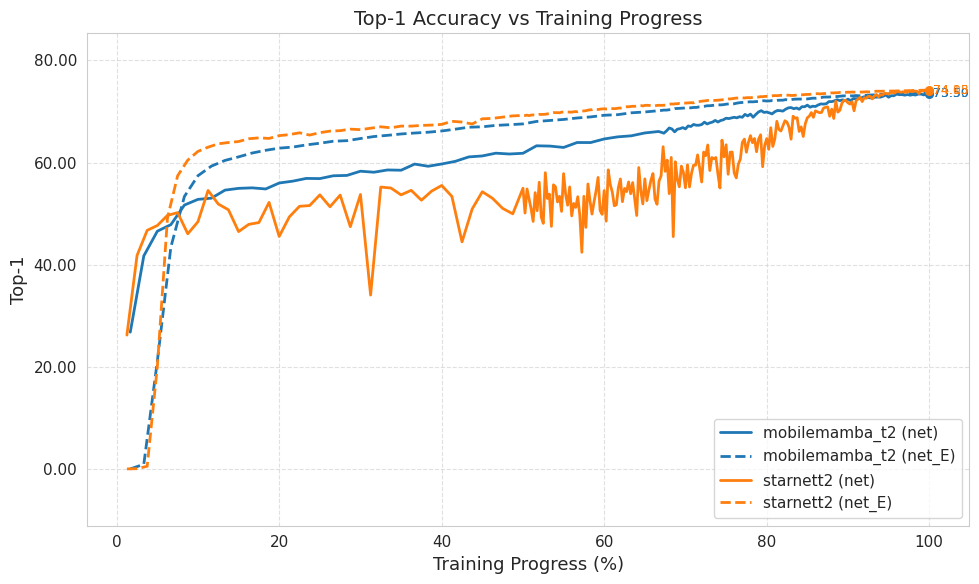

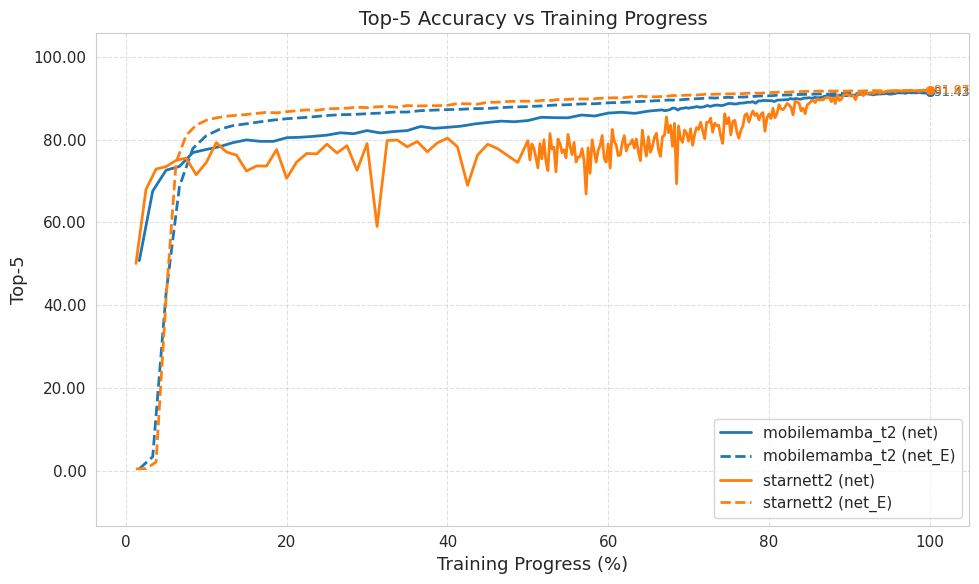


✅ Done. Plots use normalized training progress [0%, 100%].


In [12]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import uniform_filter1d
from matplotlib.ticker import FormatStrFormatter

sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 13,
    'legend.fontsize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
})

# --- 配置 ---
LOG_DIR = './logs/t2'
SMOOTH = True
SMOOTH_WINDOW = 1
MODEL_TYPE = 'both'  # 'net', 'net_E', or 'both'


def parse_log_file(log_path):
    train_data = []
    test_data = []
    last_train_epoch = 0

    with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            # Train line
            train_match = re.search(
                r"Train:.*?\[([\d\.]+)/[\d\.]+\].*?"
                r"\[lr [\d\.e\-]+\].*?"
                r"\[CE [\d\.]+ \(([\d\.]+)\)\]",
                line
            )
            if train_match:
                epoch = int(float(train_match.group(1)))
                ce_avg = float(train_match.group(2))
                last_train_epoch = epoch
                train_data.append({'epoch': epoch, 'ce_avg': ce_avg})

            # Test lines
            net_match = re.search(r"net: ([\d\.]+) \(([\d\.]+)\)", line)
            if net_match:
                test_data.append({
                    'epoch': last_train_epoch,
                    'model_type': 'net',
                    'top1': float(net_match.group(1)),
                    'top5': float(net_match.group(2))
                })

            net_e_match = re.search(r"net_E: ([\d\.]+) \(([\d\.]+)\)", line)
            if net_e_match:
                test_data.append({
                    'epoch': last_train_epoch,
                    'model_type': 'net_E',
                    'top1': float(net_e_match.group(1)),
                    'top5': float(net_e_match.group(2))
                })

    # Build DataFrames
    train_df = pd.DataFrame(train_data).drop_duplicates('epoch', keep='last').sort_values('epoch') if train_data else pd.DataFrame()
    test_df = pd.DataFrame(test_data).drop_duplicates(['epoch', 'model_type']).sort_values(['model_type', 'epoch']) if test_data else pd.DataFrame()

    # Normalize epoch to [0, 1] progress
    if not train_df.empty:
        total_ep = train_df['epoch'].max()
        test_df['progress'] = test_df['epoch'] / total_ep if total_ep > 0 else 0.0
    else:
        test_df['progress'] = 0.0

    return train_df, test_df


def parse_logs_in_dir(log_dir):
    logs = {}
    for fname in os.listdir(log_dir):
        if fname.endswith('.txt') or 'log' in fname.lower():
            path = os.path.join(log_dir, fname)
            try:
                train_df, test_df = parse_log_file(path)
                logs[fname] = {'test': test_df}
            except Exception as e:
                print(f"Error parsing {path}: {e}")
    return logs


def apply_moving_average(series, window_size=5):
    if len(series) < window_size:
        return series
    return uniform_filter1d(series.values, size=window_size, mode='nearest')


def plot_comparison_by_progress(logs, metric='top1', smooth=True, smooth_window=5, model_type='both'):
    plt.figure(figsize=(10, 6))
    model_names = list(logs.keys())
    colors = sns.color_palette("tab10", len(model_names))
    all_values = []

    for idx, (name, data) in enumerate(logs.items()):
        df = data['test']
        if df.empty or metric not in df.columns:
            continue

        color = colors[idx]
        name_clean = name.replace('.txt', '').replace('.log', '')

        if model_type == 'both':
            parts = [('net', '-'), ('net_E', '--')]
        elif model_type == 'net':
            parts = [('net', '-')]
        elif model_type == 'net_E':
            parts = [('net_E', '--')]
        else:
            continue

        for mtype, linestyle in parts:
            sub_df = df[df['model_type'] == mtype]
            if sub_df.empty:
                continue

            # Smooth if enabled
            y_raw = sub_df[metric].reset_index(drop=True)
            if smooth:
                y_plot = apply_moving_average(y_raw, smooth_window)
            else:
                y_plot = y_raw

            x_plot = sub_df['progress'] * 100  # to percentage
            all_values.extend(y_raw.dropna().tolist())

            plt.plot(x_plot, y_plot, label=f'{name_clean} ({mtype})',
                     color=color, linestyle=linestyle, linewidth=2)

            # Annotate final point
            if len(y_plot) > 0:
                xf, yf = x_plot.iloc[-1], y_plot[-1] if smooth else y_plot.iloc[-1]
                plt.scatter(xf, yf, color=color, s=30, zorder=5)
                plt.text(xf, yf, f' {yf:.2f}', fontsize=9, va='center', ha='left', color=color)

    if all_values:
        plt.xlabel('Training Progress (%)')
        plt.ylabel(metric.replace('top', 'Top-').title())
        title = f"{'Top-1' if metric == 'top1' else 'Top-5'} Accuracy vs Training Progress"
        plt.title(title)
        plt.legend(loc='best')
        plt.grid(True, linestyle='--', alpha=0.6)

        # Auto y-lim with margin
        y_min, y_max = min(all_values), max(all_values)
        margin = (y_max - y_min) * 0.15 if y_max != y_min else 0.1
        plt.ylim(y_min - margin, y_max + margin)

        # Show 2 decimal places
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        plt.tight_layout()
        plt.show()
    else:
        print("No data to plot.")


if __name__ == '__main__':
    logs = parse_logs_in_dir(LOG_DIR)
    if not logs:
        print(f"No valid log files found in {LOG_DIR}.")
        exit()

    # Plot Top-1 and Top-5
    plot_comparison_by_progress(logs, metric='top1', smooth=SMOOTH, smooth_window=SMOOTH_WINDOW, model_type=MODEL_TYPE)
    plot_comparison_by_progress(logs, metric='top5', smooth=SMOOTH, smooth_window=SMOOTH_WINDOW, model_type=MODEL_TYPE)

    print("\n✅ Done. Plots use normalized training progress [0%, 100%].")

In [4]:
import re
import os
import pandas as pd
import numpy as np
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter  # 使用PyTorch的tensorboard
import subprocess
import webbrowser

def parse_log_file(log_path):
    """
    从日志文件中解析出训练和测试数据（包括 EMA 模型）
    """
    train_data = []
    test_data = []

    last_train_epoch = 0

    with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()

    for line_num, line in enumerate(lines, 1):
        # 匹配训练日志
        train_match = re.search(
            r"Train:.*?\[\d+/\d+\].*?\[([\d\.]+)/([\d\.]+)\].*?"
            r"\[lr ([\d\.e\-]+)\].*?"
            r"\[CE ([\d\.]+) \(([\d\.]+)\)\]",
            line
        )
        if train_match:
            try:
                current_epoch_float = float(train_match.group(1))
                total_epochs = float(train_match.group(2))
                lr = float(train_match.group(3))
                ce_loss = float(train_match.group(4))
                ce_avg = float(train_match.group(5))

                epoch = int(current_epoch_float)
                last_train_epoch = epoch

                train_data.append({
                    'epoch': epoch,
                    'step': epoch,
                    'lr': lr,
                    'ce_loss': ce_loss,
                    'ce_avg': ce_avg,
                    'log_file': os.path.basename(log_path)
                })
            except (ValueError, IndexError) as e:
                print(f"Warning: Error parsing train data at line {line_num}: {e}")

        # 匹配原始模型测试结果
        test_net_match = re.search(r"net: ([\d\.]+) \(([\d\.]+)\)", line)
        if test_net_match:
            try:
                top1 = float(test_net_match.group(1))
                top5 = float(test_net_match.group(2))
                test_epoch = last_train_epoch
                test_data.append({
                    'epoch': test_epoch,
                    'step': test_epoch,
                    'model_type': 'net',
                    'top1': top1,
                    'top5': top5,
                    'log_file': os.path.basename(log_path)
                })
            except (ValueError, IndexError) as e:
                print(f"Warning: Error parsing net test data at line {line_num}: {e}")

        # 匹配EMA模型测试结果
        test_net_e_match = re.search(r"net_E: ([\d\.]+) \(([\d\.]+)\)", line)
        if test_net_e_match:
            try:
                top1_ema = float(test_net_e_match.group(1))
                top5_ema = float(test_net_e_match.group(2))
                test_epoch_ema = last_train_epoch
                test_data.append({
                    'epoch': test_epoch_ema,
                    'step': test_epoch_ema,
                    'model_type': 'net_E',
                    'top1': top1_ema,
                    'top5': top5_ema,
                    'log_file': os.path.basename(log_path)
                })
            except (ValueError, IndexError) as e:
                print(f"Warning: Error parsing net_E test data at line {line_num}: {e}")

    # 数据处理
    if train_data:
        train_df = pd.DataFrame(train_data)
        train_df = train_df.sort_values(by='epoch').drop_duplicates(subset=['epoch'], keep='last')
    else:
        train_df = pd.DataFrame(columns=['epoch', 'step', 'lr', 'ce_loss', 'ce_avg', 'log_file'])

    if test_data:
        test_df = pd.DataFrame(test_data)
        test_df = test_df.drop_duplicates(subset=['epoch', 'model_type']).sort_values(by=['model_type', 'epoch'])
    else:
        test_df = pd.DataFrame(columns=['epoch', 'step', 'model_type', 'top1', 'top5', 'log_file'])

    return train_df, test_df

def create_combined_tensorboard(logs, output_dir='./tb_logs_combined'):
    """
    创建合并的TensorBoard日志，便于对比不同实验
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    writer = SummaryWriter(output_dir)
    
    print("Creating combined TensorBoard logs...")
    
    for log_name, data in logs.items():
        log_clean_name = Path(log_name).stem
        train_df = data['train']
        test_df = data['test']
        
        print(f"Processing {log_name}...")
        
        # 写入训练数据
        if not train_df.empty:
            for _, row in train_df.iterrows():
                step = row['step']
                
                # 写入学习率
                writer.add_scalar(f'Learning Rate/{log_clean_name}', row['lr'], step)
                
                # 写入损失
                writer.add_scalar(f'Loss/{log_clean_name}_ce_loss', row['ce_loss'], step)
                writer.add_scalar(f'Loss/{log_clean_name}_ce_avg', row['ce_avg'], step)
        
        # 写入测试数据
        if not test_df.empty:
            for model_type in test_df['model_type'].unique():
                model_df = test_df[test_df['model_type'] == model_type]
                for _, row in model_df.iterrows():
                    step = row['step']
                    
                    # 写入准确率
                    writer.add_scalar(f'Accuracy/{log_clean_name}_{model_type}_top1', row['top1'], step)
                    writer.add_scalar(f'Accuracy/{log_clean_name}_{model_type}_top5', row['top5'], step)
    
    writer.close()
    print(f"\nCombined TensorBoard logs saved to: {output_dir}")
    return output_dir

def parse_logs_in_dir(log_dir):
    """
    解析指定目录下的所有日志文件
    """
    logs = {}
    log_extensions = ['.txt', '.log', '.out']
    
    for fname in os.listdir(log_dir):
        file_path = Path(log_dir) / fname
        if file_path.suffix.lower() in log_extensions or 'log' in fname.lower():
            path = str(file_path)
            print(f"Parsing {path}...")
            try:
                train_df, test_df = parse_log_file(path)
                logs[fname] = {'train': train_df, 'test': test_df}
                print(f"  - Train records: {len(train_df)}, Test records: {len(test_df)}")
            except Exception as e:
                print(f"  - Error parsing {path}: {e}")
    return logs

def start_tensorboard(logdir, port=6006):
    """
    启动TensorBoard并打开浏览器
    """
    try:
        # 构建tensorboard命令
        cmd = ['tensorboard', '--logdir', logdir, '--port', str(port), '--host', 'localhost', '--load_fast=false']
        
        print(f"Starting TensorBoard with command: {' '.join(cmd)}")
        print(f"TensorBoard will be available at: http://localhost:{port}")
        
        # 在后台启动tensorboard
        process = subprocess.Popen(cmd)
        
        # 自动打开浏览器
        webbrowser.open(f'http://localhost:{port}')
        
        print("TensorBoard started successfully!")
        print("Press Ctrl+C to stop TensorBoard")
        
        try:
            process.wait()
        except KeyboardInterrupt:
            print("\nStopping TensorBoard...")
            process.terminate()
            process.wait()
            print("TensorBoard stopped.")
            
    except FileNotFoundError:
        print("Error: tensorboard not found. Please install it:")
        print("pip install tensorboard")
    except Exception as e:
        print(f"Error starting TensorBoard: {e}")

def print_summary(logs):
    """打印日志数据摘要"""
    print("\n" + "="*60)
    print("LOG DATA SUMMARY")
    print("="*60)
    
    for name, data in logs.items():
        train_df = data['train']
        test_df = data['test']
        
        print(f"\n{os.path.basename(name)}:")
        print(f"  - Training epochs: {len(train_df)} (epochs {train_df['epoch'].min() if not train_df.empty else 0} - {train_df['epoch'].max() if not train_df.empty else 0})")
        print(f"  - Test records: {len(test_df)}")
        
        if not test_df.empty:
            for model_type in test_df['model_type'].unique():
                model_df = test_df[test_df['model_type'] == model_type]
                if not model_df.empty:
                    print(f"    {model_type}: Top-1 avg={model_df['top1'].mean():.2f}, Top-5 avg={model_df['top5'].mean():.2f}")

if __name__ == '__main__':
    # 配置
    LOG_DIR = './logs'
    TB_COMBINED_DIR = './tb_logs_combined'
    
    print("Step 1: Parsing log files...")
    logs = parse_logs_in_dir(LOG_DIR)

    if not logs:
        print(f"No log files found in {LOG_DIR}. Please check the path.")
        exit()

    # 打印数据摘要
    print_summary(logs)

    # 创建合并的TensorBoard日志
    print("\nStep 2: Creating TensorBoard logs...")
    tb_dir = create_combined_tensorboard(logs, TB_COMBINED_DIR)

    # 启动TensorBoard
    print("\nStep 3: Starting TensorBoard...")
    start_tensorboard(tb_dir, port=6006)

Step 1: Parsing log files...
Parsing logs/mobilemamba_t2.txt...
  - Train records: 301, Test records: 280
Parsing logs/startnett4.txt...
  - Train records: 401, Test records: 480
Parsing logs/mobilemamba_t4.txt...
  - Train records: 301, Test records: 280
Parsing logs/starnett8.txt...
  - Train records: 126, Test records: 50
Parsing logs/mobilemamba_s6.txt...
  - Train records: 301, Test records: 280
Parsing logs/starnett2.txt...
  - Train records: 401, Test records: 480
Parsing logs/mobilemamba_b1.txt...
  - Train records: 301, Test records: 280

LOG DATA SUMMARY

mobilemamba_t2.txt:
  - Training epochs: 301 (epochs 0 - 300)
  - Test records: 280
    net: Top-1 avg=66.75, Top-5 avg=87.23
    net_E: Top-1 avg=68.85, Top-5 avg=87.85

startnett4.txt:
  - Training epochs: 401 (epochs 0 - 400)
  - Test records: 480
    net: Top-1 avg=66.11, Top-5 avg=86.91
    net_E: Top-1 avg=73.01, Top-5 avg=90.75

mobilemamba_t4.txt:
  - Training epochs: 301 (epochs 0 - 300)
  - Test records: 280
    ne

TensorFlow installation not found - running with reduced feature set.
TensorBoard 2.14.0 at http://localhost:6006/ (Press CTRL+C to quit)



Stopping TensorBoard...
TensorBoard stopped.
